In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_clust_cos_tcn import Sub_Clust_Cos_TCN

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

In [3]:
T_train = 995 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 2
sub_no = 6
E_no = 2000
I_no = 200
T_no = 500
device = torch.device("cuda")

batch_length = 50000
batch_size = 5
iter_no = 9920*2
epoch_no = iter_no*batch_length*batch_size//T_train 

# Preprocess

In [4]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

# Train

In [5]:
model = Sub_Clust_Cos_TCN(sub_no, E_no, I_no, T_no, H_no, device)
syn_params = []
rest_params = []

for name, params in model.named_parameters():
    if (name == "C_syn_e_raw") or (name == "C_syn_i_raw"):
        syn_params.append(params)
    else:
        rest_params.append(params)

optimizer = torch.optim.Adam(rest_params, lr = 0.005)
syn_optimizer = torch.optim.Adam(syn_params, lr = 0.005)

syn_scheduler = torch.optim.lr_scheduler.StepLR(syn_optimizer, step_size=50, gamma=0.96)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

16001


In [ ]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


score_list = []
temp_list = np.logspace(0.5,-3,100)
temp_count = 0

beta = 1
kl_ref_e = torch.ones(sub_no, E_no).to(device) * 1/sub_no
kl_ref_i = torch.ones(sub_no, I_no).to(device) * 1/sub_no
kl_criterion = nn.KLDivLoss()

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    if (temp_count < 99) & (i%50 == 49):
        temp_count += 1
    if i%50 == 49:
        beta *= 0.9
    temp = temp_list[temp_count]
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, C_syn_e, C_syn_i  = model(batch_E_neural[:,:,:], batch_I_neural[:,:,:], temp)
    kl_loss = kl_criterion(torch.log(C_syn_e), kl_ref_e) + kl_criterion(torch.log(C_syn_i), kl_ref_i)
    
    loss = torch.mean((V_pred - batch_V[:,:])**2) + beta * kl_loss
    loss.backward()
    optimizer.step()
    syn_optimizer.step()
    syn_scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_C_syn_e, test_C_syn_i = model(test_E_neural.unsqueeze(0)[:,:,:], test_I_neural.unsqueeze(0)[:,:,:], 0.0001)
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test[:].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[:]-test_V_pred)**2).item()
        score_list.append(test_score)
        
        test_kl_loss = kl_criterion(torch.log(test_C_syn_e), kl_ref_e) + kl_criterion(torch.log(test_C_syn_i), kl_ref_i)
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6),
              np.round(test_kl_loss.item(),6),
             np.round(kl_loss.item(),6))


0 -0.607218 0.564747 0.0
49 -0.311397 0.085563 0.000347


In [7]:
print(C_syn_e)

tensor([[0.1481, 0.1465, 0.1497,  ..., 0.1593, 0.1520, 0.1465],
        [0.1765, 0.1729, 0.1745,  ..., 0.1747, 0.1564, 0.1699],
        [0.1702, 0.1756, 0.1594,  ..., 0.1762, 0.1801, 0.1700],
        [0.1618, 0.1666, 0.1694,  ..., 0.1559, 0.1741, 0.1690],
        [0.1651, 0.1614, 0.1682,  ..., 0.1539, 0.1596, 0.1681],
        [0.1782, 0.1770, 0.1788,  ..., 0.1800, 0.1778, 0.1766]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)


In [7]:
print(kl_ref_e)

tensor([[0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667,  ..., 0.1667, 0.1667, 0.1667]],
       device='cuda:0')


In [8]:
new_criterion = nn.KLDivLoss(reduction="none")
out = new_criterion(kl_ref_e, C_syn_e)
print(out)

tensor([[-0.3076, -0.3057, -0.3092,  ..., -0.3192, -0.3117, -0.3058],
        [-0.3356, -0.3323, -0.3337,  ..., -0.3339, -0.3163, -0.3295],
        [-0.3298, -0.3348, -0.3193,  ..., -0.3353, -0.3387, -0.3295],
        [-0.3217, -0.3264, -0.3290,  ..., -0.3157, -0.3334, -0.3286],
        [-0.3249, -0.3213, -0.3279,  ..., -0.3137, -0.3194, -0.3277],
        [-0.3371, -0.3360, -0.3376,  ..., -0.3386, -0.3367, -0.3357]],
       device='cuda:0', grad_fn=<KlDivBackward>)


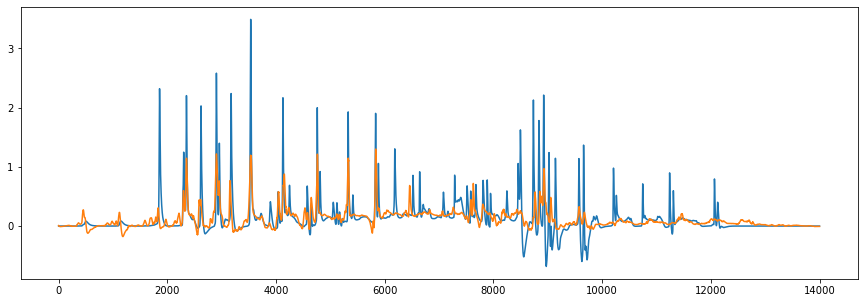

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:30000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:30000])

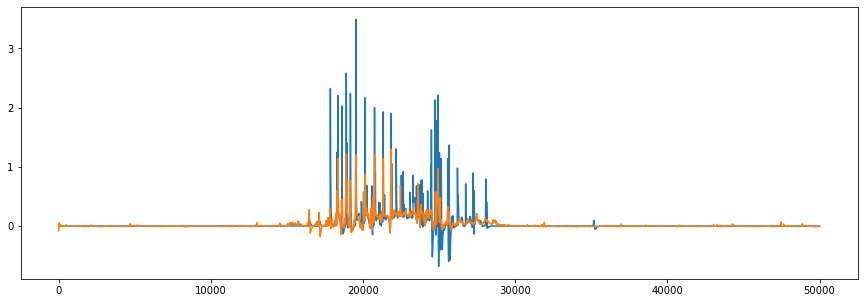

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[:])
plt.plot(test_V_pred.cpu().detach().numpy())

In [13]:
kern_basis = torch.zeros(24, T_no).to(device)
for i in range(24):
    phi = 1.5707963267948966*i
    xmin = phi - 3.141592653589793
    xmax = phi + 3.141592653589793

    x_in = torch.arange(0, T_no, 1)
    raw_cos = 6  * torch.log(x_in + 1 + 1e-7)

    basis = 0.5*torch.cos(raw_cos - phi) + 0.5
    basis[raw_cos < xmin] = 0.0
    basis[raw_cos > xmax] = 0.0
    kern_basis[i] = basis
    
kern_e = torch.matmul(model.W_e_layer1, kern_basis)
kern_i = torch.matmul(model.W_i_layer1, kern_basis)

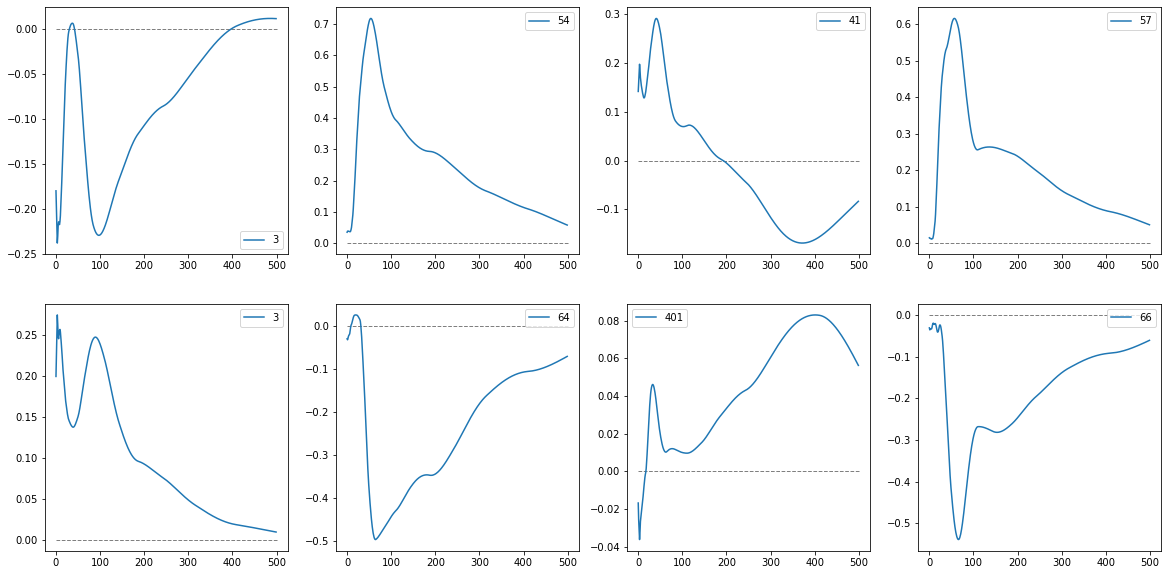

In [15]:
fig, axs = plt.subplots(nrows = H_no, ncols= sub_no, figsize = (20,10))

for i in range(H_no):
    for j in range(sub_no):
        idx = j*H_no + i
        max_t = np.argmax(np.abs(kern_e[idx].cpu().detach().numpy()))
        axs[i,j].plot(kern_e[idx].cpu().detach().numpy(), label=str(max_t))
        axs[i,j].hlines(y=0, xmin=0, xmax=T_no, linewidth=1, linestyle="--", color="gray")
        axs[i,j].legend()

In [8]:
C_syn_plot = np.zeros((E_no))

for e in range(E_no):
    C_syn_plot[e] = torch.argmax(model.C_syn_e_raw[:,e])

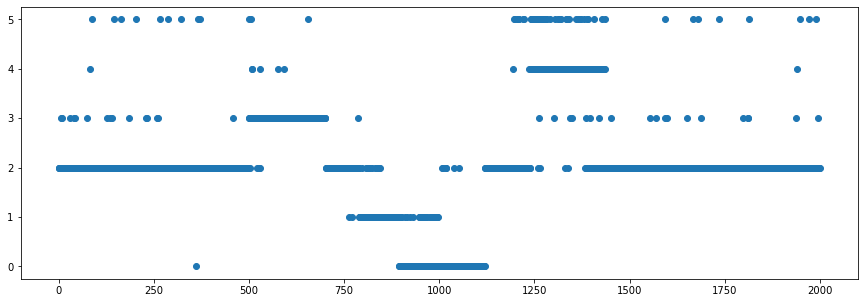

In [9]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(E_no), C_syn_plot)

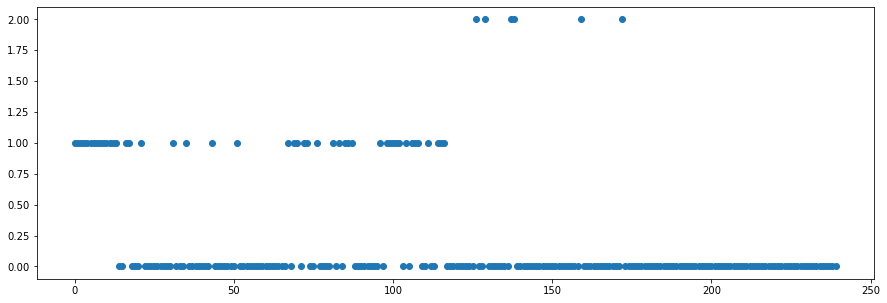

In [10]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(240), C_syn_plot[880:1120])